#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民如果每天全部时间种田可以产出 5  份粮食 # 并需要消耗一份工具(消耗量按产量变化未实装)。
   同理，村民们每天需要消耗1份工具，裁缝如果每天全部时间织布可以产出10 份工具
       村民们每天需要消耗1份衣物，裁缝如果每天全部时间织布可以产出 5 份衣物

假设每个职业都能生产别的商品，只是效率较低。我们可以给出生产效率矩阵(单位：产量/天)

裁缝：[2.5, 2.5, 5]；

农民：[5, 3.3, 3.3]；

工匠：[2.6, 10, 2.5]。

对上述模型稍加推广，令每个村民都具有如下属性：

  生产属性，即生产效率矩阵；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
村民希望库存能满足一定天数的消耗，为此他每天消耗在某项产品上的工作时长 = 生产效率^EXP(-库存/生产效率/期望库存天数)，
   可以看到，库存越多，工作时长越短，符合朴素常识。

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [209]:
# 均值化以观察图像
import numpy as np
def moving_average(lst, k=5):
    arr = np.array(lst, dtype=float)
    n = len(arr)
    half = k // 2
    
    # 先创建一个全为原始数据的结果数组
    result = arr.copy()

    # 只在能够滑动的位置做滑动均值
    for i in range(half, n - half):
        result[i] = np.mean(arr[i - half:i + half + 1])

    return result

# 画图预备包
import matplotlib.pyplot as plt
Names = ["A's ", "B's ", "C's "];
Goods = ["food", "tools", "clothes", "gold"];
Colors = ["blue", "orange", "green", "black"];
Line_types = ["-.", "--",":","o--"];
def fun_fianl(status, x, i, j):
    return [status[y][i][j] for y in x]
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def visual(status, work_times, prices, employee, wealth, k=0, names=Names, goods=Goods, colors=Colors, line_types=Line_types):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])  # 上1行，下1行，比例2:1

    # 第一幅图：库存状态图，占左上两列
    ax1 = fig.add_subplot(gs[0, :-1])
    x = range(len(status))
    for i in range(len(status[0])):
        for j in range(len(status[0][0])):
            ax1.plot(x, fun_fianl(status, x, i, j), line_types[j], label=names[i] + goods[j], color=colors[i])
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Status')
    ax1.legend(loc=1)
    ax1.grid()

    # 第二幅图：工作时间图，占左下角
    ax2 = fig.add_subplot(gs[1, 0])
    y = np.array(list(map(lambda x: np.sum(x, axis=1), work_times))).T
    for i in range(len(y)):
        ax2.plot(range(len(y[0])), moving_average(y[i], k), label=names[i], color=colors[i])
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Work Time')
    ax2.legend(loc='best')
    ax2.grid()

    # 第三幅图：价格图，占右上角
    ax3 = fig.add_subplot(gs[0, 2])
    z = np.array(prices).T
    z = z / z[0]  # 归一化
    for i in range(len(z)):
        ax3.plot(range(len(z[0])), moving_average(z[i], k), line_types[i], label=goods[i], color="black")
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Goods Prices')
    ax3.legend(loc='best')
    ax3.grid()
    
    # 第四幅图：从业者数量图，占正下方
    ax4 = fig.add_subplot(gs[1, 1])
    e = np.array(employee).T
    for i in range(len(e)):
        ax4.plot(range(len(e[0])), moving_average(e[i],k), label=names[i], color=colors[i])
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Employee')
    ax4.legend(loc='best')
    ax4.grid()
    
    # 第五幅图：从业者财富图，占右下角
    ax5 = fig.add_subplot(gs[1, 2])
    w = np.array(wealth).T
    for i in range(len(w)):
        ax5.plot(range(len(w[0])), moving_average(w[i], k), label=names[i], color=colors[i])
    ax5.set_xlabel('Day')
    ax5.set_ylabel('Wealth')
    ax5.legend(loc='best')
    ax5.grid()

    plt.tight_layout()
    plt.show()

In [6]:
import numpy as np
import copy
class IsoBlock(object): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        self.consumption = np.array( consumption, dtype=float)  # 商品消耗量
        self.product_eff = np.array(product_eff, dtype=float)  # 单位时间能生产的商品量
        self.product_time = 1 / self.product_eff # 生产单位商品所需时间
        self.status = np.array(status, dtype=float)  # 库存状态

class testBlock(IsoBlock): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_eff, status)
    def evolution(self, day):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
#         self.worktime = (-self.status * 0.2) * self.product_time
#         self.worktime[self.worktime < 0] = 0
        self.coef = (self.product_time) / day
        self.worktime = self.product_time**(self.coef * self.status)
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
#         self.consumption[:,1] = production[:,0]
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

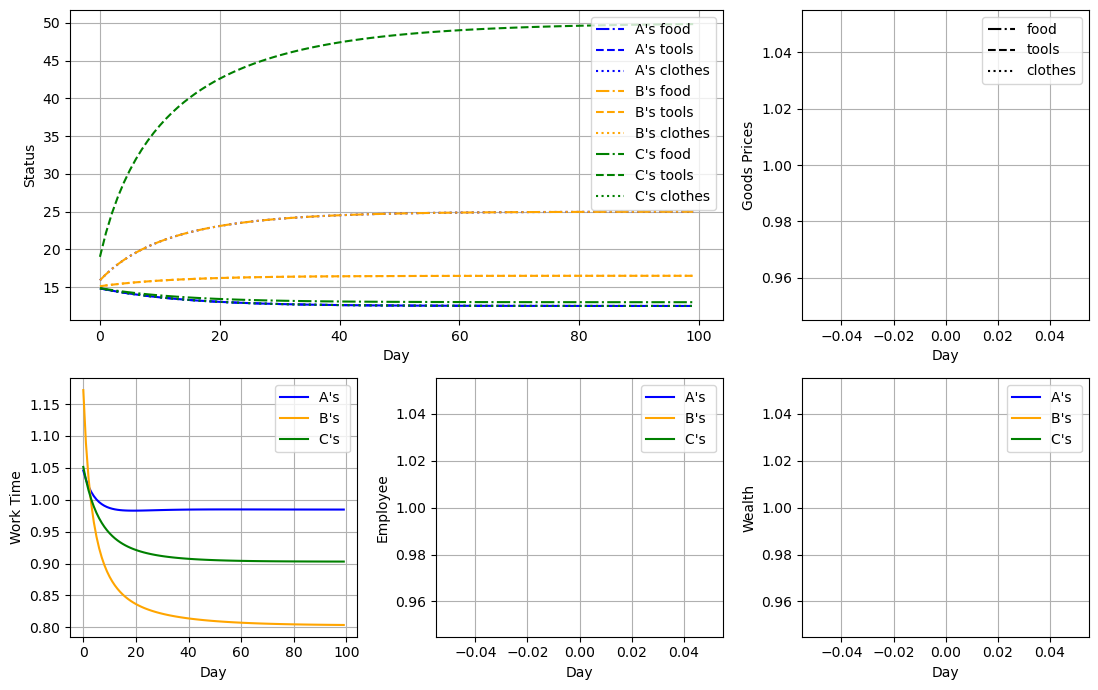

In [7]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
test = testBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.6, 10, 2.5]], 
               np.ones([j,k]) * 15)
for i in range(100):
    test.evolution(5)
    Status.append(test.status)
    Worktimes.append(test.worktime),test
visual(Status, Worktimes, [[1,1,1]], [[1,1,1]], [[1,1,1]])

In [216]:
import numpy as np
from collections import Counter
class TradeBlock(IsoBlock): 
    def __init__(self, consumption, product_eff, status, wealth, employee, hinder, trade_prices = 0):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_eff, status)
        self.wealth = np.array(wealth, dtype=float) # 各职业手中的资产
        self.employee = np.array(employee, dtype=float) # 各职业从业人数
        self.hinder = np.array(hinder, dtype=float) # 职业转换的难度
        self.trade_prices = np.array(trade_prices, dtype=float) # 商品的市场价格
        # 给出演化中不变但需要用到的常参数
        self.category = len(status[0]) # 商品种数
        self.market = np.zeros(self.category + 1)
        self.N = len(status) # 职业数
        self.x = range(self.N)
        self.voidm = np.zeros_like(self.status) # 正确维度的空矩阵空矩阵
        self.expect = np.min(self.product_time, axis=0) # 各商品的最低工作时间
        self.expect = self.expect / self.expect[0] # 用粮食价格做单位计算平衡价格
        if self.trade_prices == 0:
            self.trade_prices = self.expect # 如果不输入初始价格初始化为平衡价格
        self.prework_time = 0 #初始化抑制参数
        self.preloading = 0
    
    def evolution(self, day, reaction, feeling, willing, sensitive, isolation): 
        # day: 仓储容量，day = 10即有能用10天的货物; 
        # reaction: 当天工作时间的更新比例;
        # feeling: 衡量转职的工作时间更新比例
        # willing: 转换工作的意愿
        # sensitive: 价格对库存的敏感程度
        # isolation: 孤立程度，用于混合按劳分配与市场分配的价格
        """
        经济演化过程。
        
        """
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_eff * self.trade_prices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmax(self.feel_price, axis=1),dtype=int)
        
        #计算各职业每日拟购买的各商品量
        #需要所有商品，库存越多想买的越少，平衡于仓储容量，并加入从业人数修正
        self.needs = np.diag(self.employee) @ np.exp(-self.status / day + 1) 
#         self.needs[range(self.N), self.choice] = 0 #但不买自身的优势商品
        #对所有职业求和得到各商品量的需求量
        self.need = np.sum(self.needs, axis=0)
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.needs * self.trade_prices
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.trade_prices[self.choice]
        #计算各商品的供应量
        self.sold = self.voidm + 0
        self.sold[range(self.N),self.choice] = self.sell
        #买卖都在市场中进行
        self.market[:-1] += np.sum(self.sold - self.needs, axis=0)
        
        # 计算每日工作时间
        self.work_time = self.voidm+0#(1 - self.status * 2 / day) * self.product_time#存货不到仓储容量的一半时开始自己动手生产
#         self.work_time[self.work_time < 0] = 0 #仓储够时不生产
        coef = np.log(self.product_time[self.x, self.choice]) * (self.product_time[self.x, self.choice]) / day
        self.work_time[self.x, self.choice] = np.exp(coef * self.status[self.x, self.choice])
        self.work_time = (self.work_time * reaction + self.prework_time * (1 - reaction))
        self.work_time[self.work_time < 0.05] = 0 # 生产时间很少时直接不生产
        self.prework_time = self.work_time # 将本次生产抉择告诉下一次演化
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间 × 从业人数修正
        production = np.diag(self.employee) @ self.product_eff * self.work_time
#         self.check1 = [self.product_eff * self.work_time, production]
        
        # 计算每日非必须品消耗（工具消耗即工作时间） 
#         self.consumption[:,1] = production[:,0] #由于种田消耗工具将导致种田成本变化，影响优势商品的选取，故先不实装以测试平衡
        
        # 计算新库存状态：旧库存 - 消耗 + 生产 + 贸易变化
        self.status = self.status - self.consumption + np.diag(1 / self.employee) @ (production + self.needs - self.sold)
        # 计算货币流动
        self.exchange = np.sum((self.sold - self.needs)  * self.trade_prices, axis=1)
        self.market[-1] += -sum(self.exchange)
        self.wealth += self.exchange @ np.diag(1 / self.employee)

        #职业转换：各职业都向其他所有职业转化，转化速度与工作时间呈反比，并加入困难系数增加流出人口
        self.trans = np.zeros([self.N, self.N])
        # 计算总劳动负担（每个职业的工作时间总和）
        self.loading = feeling * np.sum(self.work_time, axis=1) + (1-feeling) * self.preloading
        self.preloading = self.loading + 0
        diff = self.loading * self.hinder
        for i in range(self.N):
            self.trans[i] = - self.loading + self.loading[i] # 观察哪个职业工作时间相对更少
            self.trans[i][self.trans[i] < 0] = 0 # 不去更累的地方
            self.trans[i][diff[i] < diff] = 0 # 将不允许转职的选择置零
            self.trans[i, i] = -sum(self.trans[i]) # 计算流出人口
            self.trans[i] = self.trans[i] * willing * self.employee[i] #计算从该职业出发的人口变化
        self.trans = (self.trans.T + np.diag(self.employee)) # 第i行j列即行业i从行业j接收到的人数（且被归一）
        self.c1 = self.trans
        self.prestatus = self.status
        self.status = np.diag(1 / self.employee) @ self.trans @ self.status # 库存转移
        self.c2 = [self.status,np.diag(1 / self.employee),self.trans,self.prestatus,self.trans @ self.prestatus]
        self.premployee = self.employee + 0
        self.employee = np.sum(self.trans, axis=1) # 新的雇员人数       
        self.wealth = self.wealth @ self.trans.T @ np.diag(1 / self.employee) # 财产转移
        
        
        # 加权供需比例作为调整价格的基数
        self.trade_prices = np.exp(-self.market[:-1] * (1 - isolation) * sensitive / day) * self.expect**isolation
#         self.trade_prices = self.trade_prices / self.trade_prices[0] # 用粮食价格做单位计算浮动的商品价格


  0%|          | 0/2500 [00:00<?, ?it/s]

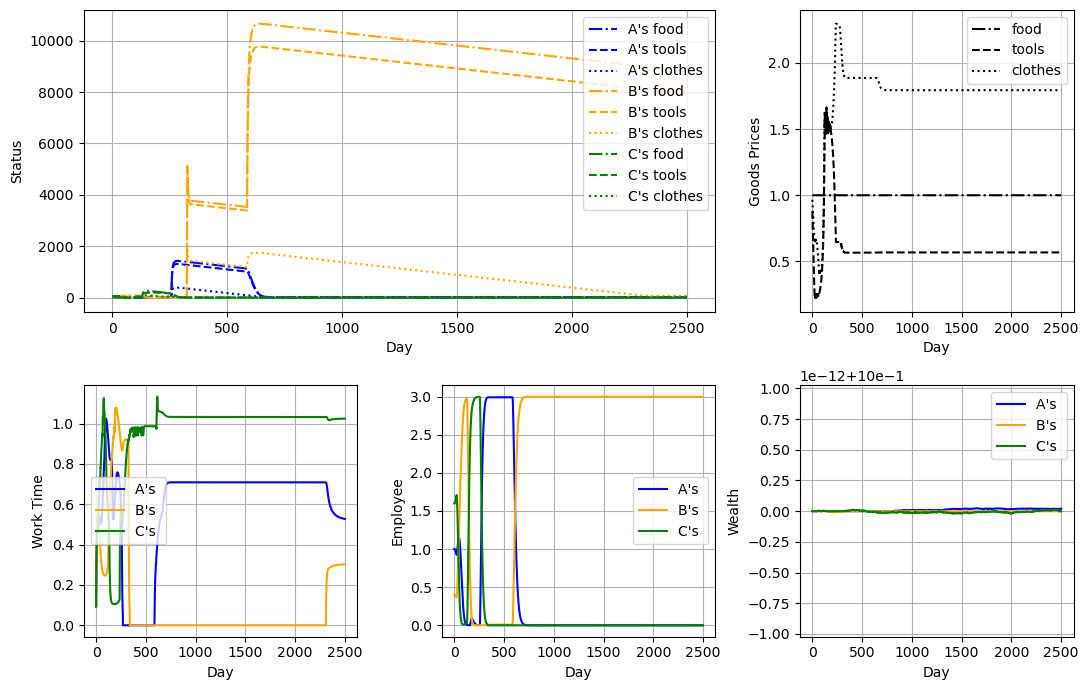

In [217]:
# 创建实例
from tqdm.notebook import tqdm
j=3; k=3;
Status = [];
Work_times = [];
Prices = [];
Wealth = [];
Employee = [];
self = TradeBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 6],[5, 3.3, 3.3], [2.5, 10, 3]], 
#                [[2,2,7],[7,2,2],[2,7,2]],
               pre,
               np.ones(j),
               [1,0.4,1.6],
               [1, 1,1])
# self = TradeBlock( 
#                np.ones([2,3]), #201,纺 农 匠
#                [[2.5, 2.5, 6],[5, 3.3, 3.3]], 
# #                [[2,2,7],[7,2,2],[2,7,2]],
#               np.ones([2,3]),
#                np.ones(2),
#                [1,0.8],
#                [1, 1])
for i in tqdm(range(2500)): # day, work_time reaction, loading feeling, change job willing, market sensitive, isolation
    self.evolution(20, 0.2, 0.7, 0.1, 0.2, 0.1)
    Status.append(self.status+0)
    Work_times.append(self.work_time+0)
    Prices.append(self.trade_prices+0)
    Wealth.append(self.wealth+0)
    Employee.append(self.employee+0)
visual(Status, Work_times, Prices, Employee, Wealth)

In [215]:
self.market

array([ 1.27058149e+01,  6.78698136e+01, -5.42464120e+01, -3.94309525e-15])

In [205]:
self.work_time

array([[0.        , 0.        , 0.54916776],
       [0.28931774, 0.        , 0.        ],
       [0.        , 0.72719533, 0.        ]])

In [204]:
self.loading

array([0.54739516, 0.29040365, 0.72360212])

In [191]:
self.employee

array([1.29690848, 1.45787857, 0.24521295])

In [190]:
self.product_eff

array([[ 2.5,  2.5,  6. ],
       [ 5. ,  3.3,  3.3],
       [ 2.5, 10. ,  3. ]])

In [188]:
np.diag(self.employee) @ self.product_eff

array([[3.2422712 , 3.2422712 , 7.78145089],
       [7.28939285, 4.81099928, 4.81099928],
       [0.61303237, 2.45212949, 0.73563885]])

In [187]:
self.work_time

array([[0.33822386, 0.        , 0.30376343],
       [0.34704596, 0.        , 0.        ],
       [0.        , 0.73494058, 0.        ]])

In [189]:
np.diag(self.employee) @ self.product_eff * self.work_time

array([[1.09661348, 0.        , 2.36372021],
       [2.52975435, 0.        , 0.        ],
       [0.        , 1.80216947, 0.        ]])

In [194]:
self.needs * self.trade_prices

array([[1.27311607, 0.4323013 , 0.33224085],
       [0.14342558, 0.45083733, 0.56432704],
       [0.28332855, 0.04609417, 0.11813767]])

In [192]:
self.needs

array([[1.27311607, 1.33204142, 0.78974699],
       [0.14342558, 1.38915611, 1.34142317],
       [0.28332855, 0.14202904, 0.28081697]])

In [193]:
self.trade_prices

array([1.        , 0.32454044, 0.42069278])

In [174]:
self.status

array([[19.55516478, 19.56490983, 32.84575795],
       [35.49523492, 20.24893279, 20.30131792],
       [20.91950688, 64.30041578, 19.80270051]])

In [175]:
self.needs

array([[0.97626405, 0.97576221, 0.50432081],
       [0.62292039, 1.3406444 , 1.33734587],
       [0.65571365, 0.06376514, 0.72392135]])

In [176]:
self.work_time

array([[0.        , 0.        , 0.61554473],
       [0.56077617, 0.        , 0.        ],
       [0.        , 0.25547809, 0.25128843]])

In [109]:
pre = test.status
pre

array([[20.        , 20.        , 51.04301544],
       [47.35442394, 20.        , 20.        ],
       [20.        , 66.19864381, 20.        ]])

工作载荷，人均财富,总财富的总量检查

In [87]:
m_loading = np.mean(np.array(list(map(lambda x: np.sum(x, axis=0), Work_times))),axis=0)
m_loading

array([0.53980535, 0.41937599, 0.58044137])

In [59]:
sum(test.wealth)

2.999999999999984

In [60]:
sum(test.wealth@np.diag(test.employee))

2.9999999999999756

In [64]:
m_emp = np.mean(np.array(Employee).T,axis=1)
m_emp

array([0.8995362 , 1.02999424, 1.07046956])

In [62]:
max_pro = np.min(test.product_time,axis=1)
max_pro

array([0.16666667, 0.2       , 0.1       ])

In [63]:
m_emp / max_pro

array([ 5.39721722,  5.14997118, 10.7046956 ])

In [981]:
np.sum(np.array([[1,2],[3,4]]),axis=0)

array([4, 6])

In [135]:
# 参数检查
for attr, value in vars(test).items():
    print(f"{attr} = {value}")

consumption = [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
product_eff = [[ 2.5  2.5  6. ]
 [ 5.   3.3  3.3]
 [ 2.5 10.   3. ]]
product_time = [[0.4        0.4        0.16666667]
 [0.2        0.3030303  0.3030303 ]
 [0.4        0.1        0.33333333]]
status = [[17.95451019 19.07986584 20.76894145]
 [66.89496138 21.26281452 21.55392414]
 [18.68127096 62.24576955 18.68363301]]
wealth = [1. 1. 1.]
employee = [1.24219294 1.53421109 0.22359598]
hinder = [1. 1. 1.]
trade_prices = [1.         0.48705737 0.4238534 ]
category = 3
market = [-4.99711840e+01  2.22575544e+01  4.33772041e+01 -9.71445147e-17]
N = 3
x = range(0, 3)
voidm = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
expect = [1.         0.5        0.83333333]
prework_time = [[0.32859233 0.         0.35529907]
 [0.34213011 0.         0.        ]
 [0.         0.57674249 0.        ]]
preloading = [0.67885078 0.34252245 0.59017261]
feel_price = [[2.5        1.17267385 2.42801279]
 [5.         1.54792948 1.33540704]
 [2.5        4.69069541 1.2140064 ]]


In [517]:
np.array([[1],[2]]) @ np.array([[3,5],[7,11]])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [516]:
import numpy as np

# 定义列向量（m x 1）
col = np.array([[1],
                [2],
                [3]])

# 定义行向量（1 x n）
row = np.array([[10, 20, 30, 40]])

# 乘法：列向量 × 行向量 = m x n 的矩阵
result = col @ row

print(result)


[[ 10  20  30  40]
 [ 20  40  60  80]
 [ 30  60  90 120]]
